###Описание набора данных и решаемой задачи:

Набор данных: "Kaggle Russian News Dataset". Это набор данных новостных статей на русском языке, анонимно опубликованный на Kaggle. Исходный файл – train.json.

Цель: исследовать и сравнить эффективность различных моделей машинного обучения для задачи классификации тональности русскоязычных новостей и разработать на основе подходящей модели прототип системы онлайн-мониторинга.

Целевая переменная: sentiment (настроение), которая после предобработки принимает значения 1 (positive) и 0 (negative).

###Метрики качества для модели:

Accuracy: Доля правильно классифицированных объектов. Подходит для общего понимания производительности, но может быть обманчива при дисбалансе классов.

Accuracy = (TP + TN) / (TP + TN + FP + FN)

Precision (Точность): Доля объектов, названных классификатором положительными и при этом действительно являющихся положительными. Важна, когда цена ложноположительного срабатывания высока.

Precision = TP / (TP + FP)

Recall (Полнота): Доля объектов положительного класса из всех объектов положительного класса, которую нашел алгоритм. Важна, когда цена пропуска положительного объекта высока.

Recall = TP / (TP + FN)

F1-score: Среднее гармоническое точности и полноты. Является хорошей метрикой, особенно при дисбалансе классов. Будут рассматриваться F1 для каждого класса, а также macro F1 (среднее F1 по классам без учета их размера) и weighted F1 (среднее F1 по классам с учетом их размера).

F1 = 2 * (Precision * Recall) / (Precision + Recall)

ROC AUC (Area Under the Receiver Operating Characteristic Curve): Площадь под ROC-кривой. ROC-кривая строится как зависимость True Positive Rate (Recall) от False Positive Rate. Метрика хорошо показывает общую способность модели разделять классы, независимо от порога классификации.

###Типичный уровень метрик:

Accuracy/F1-score (macro/weighted):

0.70 - 0.80: Удовлетворительный результат.

0.80 - 0.90: Хороший результат.

'>' 0.90: Отличный результат.

ROC AUC:

0.75 - 0.85: Удовлетворительно.

0.85 - 0.95: Хорошо.

'>' 0.95: Отлично.

###Ориентиры:

Минимальный приемлемый уровень: Macro F1 > 0.75, ROC AUC > 0.80.

Целевой уровень: Macro F1 > 0.85, ROC AUC > 0.90

###Загрузка библиотек и датасета:

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import re
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, punkt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from transformers import BertTokenizer, AutoModel
from catboost import CatBoostClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
data = pd.DataFrame(pd.read_json('train.json'))

In [3]:
data = data[data['sentiment'] != 'neutral'].copy()

### Предварительный анализ и очистка данных:

In [4]:
data.head()

,text,id,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative
1,Медики рассказали о состоянии пострадавшего му...,1957,negative
2,"Прошел почти год, как железнодорожным оператор...",1969,negative
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4229 entries, 0 to 8261
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4229 non-null   object
 1   id         4229 non-null   int64 
 2   sentiment  4229 non-null   object
dtypes: int64(1), object(2)
memory usage: 132.2+ KB


In [6]:
label_map = {'positive': 1, 'negative': 0}
data['sentiment'] = data['sentiment'].map(label_map)

In [7]:
data = data.drop(columns=['id'])

In [8]:
data.head()

,text,sentiment
0,Досудебное расследование по факту покупки ЕНПФ...,0
1,Медики рассказали о состоянии пострадавшего му...,0
2,"Прошел почти год, как железнодорожным оператор...",0
3,По итогам 12 месяцев 2016 года на территории р...,0
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,0


In [9]:
print("Размер датасета:", data.shape)

Размер датасета: (4229, 2)


In [10]:
print("Дубликаты:", data.duplicated().sum())

Дубликаты: 0


In [11]:
data['sentiment'].value_counts()

,count
sentiment,
1,2795
0,1434


In [12]:
print(data.isnull().sum())

text         0
sentiment    0
dtype: int64


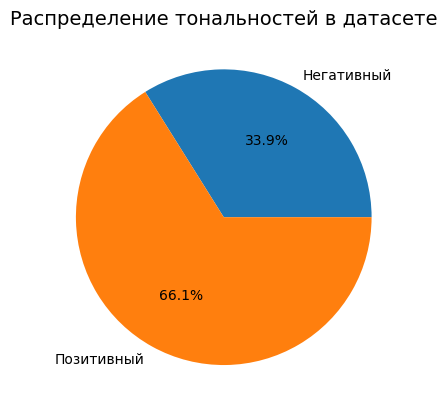

In [13]:
label_names = {1: 'Позитивный', 0: 'Негативный'}
label_counts = data['sentiment'].value_counts().sort_index()

plt.pie(label_counts, labels=[label_names[i] for i in label_counts.index], autopct='%1.1f%%')
plt.title('Распределение тональностей в датасете', fontsize=14)
plt.show()

###Преобразование данных:

Для анализа текстовых данных необходимо преобразовать их в числовой формат, понятный моделям машинного обучения. В данной работе используются два основных подхода к векторизации текстов:

1. Для BERT (RuBERT):

Токенизация с BertTokenizer (subwords).

Токены → числовые ID, добавление [CLS] и [SEP].

Приведение к длине 256 (обрезание/дополнение [PAD]).

Создание маски внимания (attention_mask).

Результат: тензоры input_ids и attention_mask.

2. Для классических моделей (LR, SVM, CatBoost, NN):

Очистка: нижний регистр, удаление спецсимволов.

Токенизация (word_tokenize), удаление стоп-слов.

Векторизация (TF-IDF):

max_features=5000/10000 (топ слов/n-грамм).

ngram_range=(1, 2) (униграммы + биграммы).


In [14]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
MAX_LEN = 256

def tokenize_texts(texts):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


###Разделение набора данных:

Данные разделяются на три части:

Обучающая выборка (Training set) 80%: Используется для обучения модели, т.е. для подбора ее весов/параметров.

Валидационная выборка (Validation set) 10%: Используется для настройки гиперпараметров модели (например, количество эпох, скорость обучения, параметры регуляризации) и для отслеживания переобучения в процессе тренировки. Модель не обучается напрямую на этих данных, но они влияют на выбор лучшей конфигурации модели.

Тестовая выборка (Test set) 10%: Используется для финальной, независимой оценки качества обученной и настроенной модели. Эти данные модель "видит" только один раз, после завершения всех этапов обучения и настройки.



In [15]:
texts = list(data['text'])
labels = np.array(data['sentiment'])

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=17, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 3383, Val: 423, Test: 423


###Принципиальная архитектура нейросетевой модели (на основе BERT):

1. Основа (Backbone)

RuBERT (sberbank-ai/ruBert-base) – предобученная BERT-модель для русского языка.

На вход: токенизированный текст (input_ids, attention_mask).

На выходе: эмбеддинги токенов + pooler_output (векторное представление всего текста, 768D).

2. Классификационная голова (Classifier Head)

Dropout (p=0.3) – регуляризация.

Linear-слой – преобразует эмбеддинг в логиты.

3. Функция потерь и регуляризация

Loss: CrossEntropyLoss с весами классов.

L2-регуляризация: weight_decay=1e-2 (в оптимизаторе AdamW).


###Возможные варианты модификации модели:

1. Изменение архитектуры:

Добавление большего количества линейных слоев (например, Linear -> ReLU -> Dropout -> Linear).

Использование других функций активации (например, GeLU).

2. Заморозка большего количества слоев BERT: По умолчанию при fine-tuning обучаются все слои BERT. Можно попробовать заморозить часть нижних слоев BERT, обучая только верхние и классификационную голову.

3. Использование другой предобученной модели BERT.

In [17]:
class SentimentClassifier(nn.Module):
    def __init__(self, model_name="sberbank-ai/ruBert-base", n_classes=2, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(self.dropout(pooled))

###Реализация модели и процесса обучения на PyTorch:

RuBertDataset(Dataset) (Класс для загрузки данных):

* Наследуется от torch.utils.data.Dataset.

* В конструкторе __init__ принимает списки текстов и меток.

* Вызывает функцию tokenize_texts_for_bert (определенную в п.3) для преобразования текстов в input_ids и attention_mask.

* Метки преобразуются в тензоры torch.long.

* Метод __len__ возвращает общее количество примеров в датасете.

* Метод __getitem__ возвращает один пример данных (словарь с input_ids, attention_mask, labels) по индексу.


---


DataLoader (Объект для подачи данных батчами):

* Создаются отдельные DataLoader'ы для обучающей (train_loader) и валидационной (val_loader) выборок.

* batch_size: Определяет количество примеров, обрабатываемых за одну итерацию обучения/оценки (в коде batch_size=32).

* shuffle=True для train_loader: Данные в обучающей выборке перемешиваются перед каждой эпохой, что способствует лучшей сходимости модели. Для валидационной выборки перемешивание не обязательно.


---


train_epoch (Функция для одной эпохи обучения):

* Принимает модель, DataLoader для обучающей выборки, оптимизатор, функцию потерь и устройство (CPU/GPU).

* Переводит модель в режим обучения (model.train()).

* Итерируется по батчам данных из loader.

Для каждого батча:

* Обнуляет градиенты (optimizer.zero_grad()).

* Перемещает данные на device.

* Выполняет прямой проход (outputs = model(...)).

* Вычисляет потери (loss = criterion(...)).

* Выполняет обратный проход для расчета градиентов (loss.backward()).

* Обновляет веса модели (optimizer.step()).

* Агрегирует общие потери и количество правильно предсказанных примеров для расчета метрик эпохи.

Возвращает средние потери и точность на обучающей выборке за эпоху.


---


eval_epoch (Функция для оценки модели за одну эпоху):

* Принимает модель, DataLoader для валидационной/тестовой выборки, функцию потерь и устройство.

* Переводит модель в режим оценки (model.eval()). Это отключает слои типа Dropout и BatchNorm (если они есть и работают по-разному в режимах train/eval).

* Обертывает цикл оценки в torch.no_grad() для отключения расчета градиентов, что ускоряет вычисления и экономит память.

* Итерируется по батчам данных.

Для каждого батча:

* Перемещает данные на device.

* Выполняет прямой проход.

* Вычисляет потери.

* Агрегирует общие потери и количество правильно предсказанных примеров.

Возвращает средние потери и точность на данной выборке за эпоху.

In [18]:
class RuBertDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attn_masks = tokenize_texts(texts)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
            'labels': self.labels[idx]
        }

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0.0, 0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), total_correct / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0.0, 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), total_correct / len(loader.dataset)

###Вывод промежуточных и финальных метрик:

Промежуточные метрики: В цикле обучения после каждой эпохи выводятся:

* Номер эпохи.

* Время, затраченное на эпоху.

* Потери (loss) и точность (accuracy) на обучающей выборке (train_loss, train_acc).

* Потери (loss) и точность (accuracy) на валидационной выборке (val_loss, val_acc).

Эти метрики сохраняются в словаре history для последующей визуализации кривых обучения.

###Настройка параметров входных данных:

MAX_LEN = 256: Максимальная длина последовательности токенов для BERT. Тексты длиннее будут обрезаны, короче – дополнены padding-токенами. Это значение является компромиссом между охватом информации и вычислительными ресурсами.

###Параметры обучения (гиперпараметры):

* Устройство (device): torch.device("cuda" if torch.cuda.is_available() else "cpu"). Обучение будет проводиться на GPU, если доступно, иначе на CPU. GPU значительно ускоряет обучение нейронных сетей.

* Размер батча (batch_size): 32. Количество примеров, обрабатываемых моделью за одну итерацию перед обновлением весов. Влияет на стабильность обучения и использование памяти.

* Оптимизатор (optimizer): torch.optim.AdamW. Это вариант оптимизатора Adam, который лучше справляется с L2-регуляризацией (weight decay).

* Скорость обучения (lr): 0.00002.

* weight_decay: 0.01. Коэффициент L2-регуляризации.

* Функция потерь (criterion): nn.CrossEntropyLoss.

* Веса классов (class_weights): torch.tensor([1.0, 66.0/34.0]). Присваивают больший вес миноритарному классу (предположительно, позитивному, если его доля 34%) для борьбы с дисбалансом.

* Количество эпох (EPOCHS): 10. Количество полных проходов по всему обучающему набору данных.

###Процесс обучения:



In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_ds = RuBertDataset(X_train, y_train)
val_ds = RuBertDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

model = SentimentClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00002, weight_decay=0.01)
class_weights = torch.tensor([1.0, 66/34], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

EPOCHS = 10
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

start_time = time.time()
for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
    epoch_time = time.time() - epoch_start

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch {epoch}/{EPOCHS} — time: {epoch_time:.1f}s | "
          f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

total_time = time.time() - start_time
print(f"\nОбщее время обучения: {total_time/60:.2f} мин")

Epoch 1/10 — time: 144.1s | train_loss: 0.4958, train_acc: 0.6769 | val_loss: 0.3889, val_acc: 0.7636
Epoch 2/10 — time: 144.2s | train_loss: 0.3042, train_acc: 0.8321 | val_loss: 0.2601, val_acc: 0.8227
Epoch 3/10 — time: 144.2s | train_loss: 0.1709, train_acc: 0.9161 | val_loss: 0.2046, val_acc: 0.8865
Epoch 4/10 — time: 144.0s | train_loss: 0.1063, train_acc: 0.9527 | val_loss: 0.2264, val_acc: 0.8983
Epoch 5/10 — time: 144.1s | train_loss: 0.0535, train_acc: 0.9793 | val_loss: 0.3211, val_acc: 0.9173
Epoch 6/10 — time: 144.2s | train_loss: 0.0277, train_acc: 0.9902 | val_loss: 0.5031, val_acc: 0.8913
Epoch 7/10 — time: 144.0s | train_loss: 0.0389, train_acc: 0.9834 | val_loss: 0.6594, val_acc: 0.8511
Epoch 8/10 — time: 143.9s | train_loss: 0.0336, train_acc: 0.9858 | val_loss: 0.4609, val_acc: 0.8913
Epoch 9/10 — time: 144.0s | train_loss: 0.0147, train_acc: 0.9947 | val_loss: 0.3979, val_acc: 0.9102
Epoch 10/10 — time: 143.9s | train_loss: 0.0137, train_acc: 0.9956 | val_loss: 0.4

###Оценка качества лучшей модели (RuBERT):



In [20]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_ds = RuBertDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=32)

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['Негатив', 'Позитив'], digits=4))

              precision    recall  f1-score   support

     Негатив     0.8529    0.8056    0.8286       144
     Позитив     0.9024    0.9283    0.9152       279

    accuracy                         0.8865       423
   macro avg     0.8777    0.8669    0.8719       423
weighted avg     0.8856    0.8865    0.8857       423



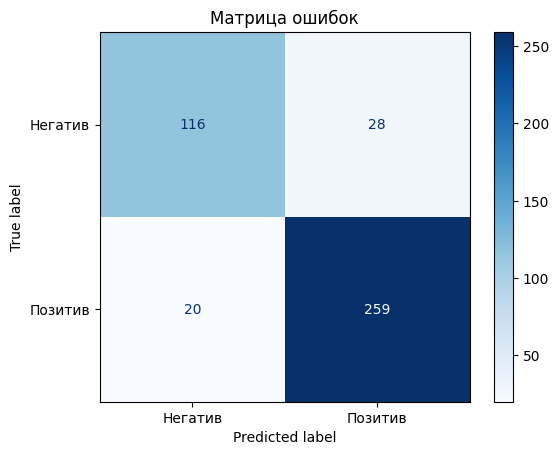

In [21]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Негатив', 'Позитив'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Матрица ошибок")
plt.show()

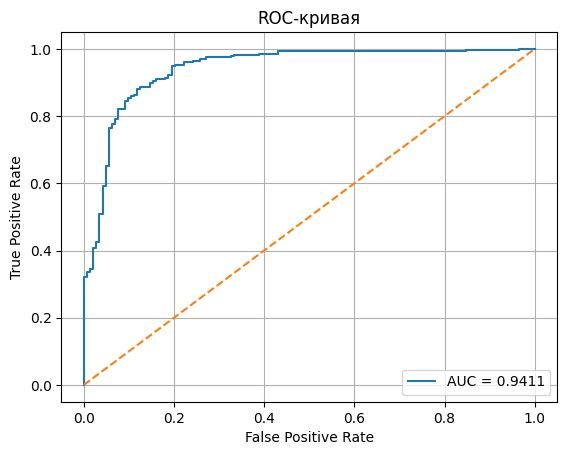

In [22]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid()
plt.show()

###Проверка на переобучение:

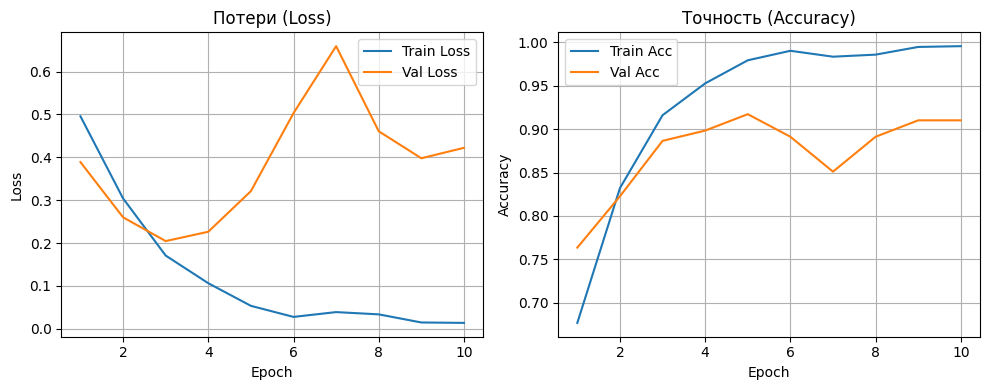

In [23]:
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Потери (Loss)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Acc')
plt.plot(epochs_range, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Точность (Accuracy)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

###Обучение и оценка качества для несколько альтернативных архитектур:

In [64]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text, language='russian')
    stop_words = set(stopwords.words('russian'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [65]:
data = pd.read_json('train.json')
data = data[data['sentiment'] != 'neutral'].copy()
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
data['cleaned_text'] = data['text'].apply(preprocess_text)

####Logistic Regression (Логистическая регрессия):

In [66]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(data['cleaned_text'])
y = data['sentiment'].values

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=17)

In [72]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)

In [73]:
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [74]:
y_pred_LR = lr_model.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred_LR, target_names=['Негатив', 'Позитив']))

              precision    recall  f1-score   support

     Негатив       0.87      0.85      0.86       287
     Позитив       0.93      0.93      0.93       559

    accuracy                           0.91       846
   macro avg       0.90      0.89      0.90       846
weighted avg       0.91      0.91      0.91       846



####CatBoostClassifier (Градиентный бустинг):

In [32]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(data['cleaned_text'])
y = data['sentiment'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=17)

In [34]:
model_CB = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    class_weights= [1.0, 66.0/34.0],
    verbose=100
)

In [35]:
model_CB.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=8)

0:	learn: 0.6477368	test: 0.6475962	best: 0.6475962 (0)	total: 602ms	remaining: 10m 1s
100:	learn: 0.1951436	test: 0.2465060	best: 0.2465060 (100)	total: 42.5s	remaining: 6m 17s
200:	learn: 0.1226005	test: 0.2163108	best: 0.2163108 (200)	total: 1m 25s	remaining: 5m 39s
300:	learn: 0.0869936	test: 0.2030857	best: 0.2030857 (300)	total: 2m 7s	remaining: 4m 55s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 0.2028901675
bestIteration = 302

Shrink model to first 303 iterations.


In [36]:
y_pred_CB = model_CB.predict(X_test)
print(classification_report(y_test, y_pred_CB, target_names=['Негатив', 'Позитив']))

              precision    recall  f1-score   support

     Негатив       0.93      0.74      0.83       287
     Позитив       0.88      0.97      0.92       559

    accuracy                           0.89       846
   macro avg       0.91      0.86      0.88       846
weighted avg       0.90      0.89      0.89       846



####LinearSVC (Метод опорных векторов):

In [37]:
data['cleaned_text'] = data['text'].apply(preprocess_text)

In [38]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(data['cleaned_text'])
y = data['sentiment'].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=17
)

In [40]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}

In [41]:
grid_search = GridSearchCV(
    estimator=LinearSVC(max_iter=5000),
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

In [42]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=5000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'loss': ['hinge', 'squared_hinge']},
             scoring='f1_macro')

In [43]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'C': 1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}


In [44]:
model_SVC = grid_search.best_estimator_
y_pred_SVC = model_SVC.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred_SVC, target_names=['Негатив', 'Позитив']))

              precision    recall  f1-score   support

     Негатив       0.89      0.85      0.87       287
     Позитив       0.92      0.95      0.94       559

    accuracy                           0.91       846
   macro avg       0.91      0.90      0.90       846
weighted avg       0.91      0.91      0.91       846



####SimpleNN (Простая 2-слойная нейронная сеть):

In [46]:
data['cleaned_text'] = data['text'].apply(preprocess_text)

In [47]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(data['cleaned_text']).toarray()
y = data['sentiment'].values

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=17
)

In [49]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [50]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

In [51]:
model_NN = SimpleNN(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_NN.parameters(), lr=0.01)

In [52]:
epochs = 20
for epoch in range(epochs):
    model_NN.train()
    optimizer.zero_grad()
    outputs = model_NN(X_train_tensor)
    train_loss = criterion(outputs, y_train_tensor)
    train_loss.backward()
    optimizer.step()
    model_NN.eval()
    with torch.no_grad():
        test_outputs = model_NN(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

Epoch 1/20 | Train Loss: 0.6719 | Test Loss: 0.6116
Epoch 2/20 | Train Loss: 0.6091 | Test Loss: 0.5495
Epoch 3/20 | Train Loss: 0.5430 | Test Loss: 0.4887
Epoch 4/20 | Train Loss: 0.4771 | Test Loss: 0.4309
Epoch 5/20 | Train Loss: 0.4126 | Test Loss: 0.3767
Epoch 6/20 | Train Loss: 0.3510 | Test Loss: 0.3305
Epoch 7/20 | Train Loss: 0.2974 | Test Loss: 0.2965
Epoch 8/20 | Train Loss: 0.2565 | Test Loss: 0.2727
Epoch 9/20 | Train Loss: 0.2257 | Test Loss: 0.2540
Epoch 10/20 | Train Loss: 0.1994 | Test Loss: 0.2388
Epoch 11/20 | Train Loss: 0.1754 | Test Loss: 0.2290
Epoch 12/20 | Train Loss: 0.1551 | Test Loss: 0.2247
Epoch 13/20 | Train Loss: 0.1395 | Test Loss: 0.2234
Epoch 14/20 | Train Loss: 0.1269 | Test Loss: 0.2221
Epoch 15/20 | Train Loss: 0.1151 | Test Loss: 0.2200
Epoch 16/20 | Train Loss: 0.1033 | Test Loss: 0.2181
Epoch 17/20 | Train Loss: 0.0917 | Test Loss: 0.2175
Epoch 18/20 | Train Loss: 0.0805 | Test Loss: 0.2191
Epoch 19/20 | Train Loss: 0.0703 | Test Loss: 0.2231
Ep

In [53]:
model_NN.eval()
with torch.no_grad():
    outputs = model_NN(X_test_tensor)
    preds = torch.argmax(outputs, dim=1).numpy()

print("Оценка модели:")
print(classification_report(y_test, preds, target_names=["Негатив", "Позитив"]))

Оценка модели:
              precision    recall  f1-score   support

     Негатив       0.92      0.84      0.87       287
     Позитив       0.92      0.96      0.94       559

    accuracy                           0.92       846
   macro avg       0.92      0.90      0.91       846
weighted avg       0.92      0.92      0.92       846



###Сбор и визуализация результатов:



In [62]:
def extract_metrics(y_true, y_pred, y_proba, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, target_names=["Негатив", "Позитив"])
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"],
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

In [76]:
lr_proba = lr_model.predict_proba(X_test)[:, 1]
cb_proba = model_CB.predict_proba(X_test)[:, 1]
svm_proba = model_SVC.decision_function(X_test)
nn_proba = F.softmax(model_NN(X_test_tensor), dim=1)[:, 1].detach().numpy()

In [77]:
results = pd.DataFrame([
    extract_metrics(y_test, y_pred_LR, lr_proba, "LR"),
    extract_metrics(y_test, y_pred_CB, cb_proba, "CatBoost"),
    extract_metrics(y_test, y_pred_SVC, svm_proba, "SVM"),
    extract_metrics(y_test, preds, nn_proba, "NN"),
    extract_metrics(all_labels, all_preds, all_probs, "RuBERT")
])

In [84]:
results.round(3)

,Model,Accuracy,Macro F1,Weighted F1,ROC AUC
0,LR,0.907,0.895,0.906,0.964
1,CatBoost,0.895,0.876,0.891,0.960
2,SVM,0.914,0.903,0.913,0.965
3,NN,0.918,0.907,0.917,0.970
4,RuBERT,0.925,0.912,0.922,0.974


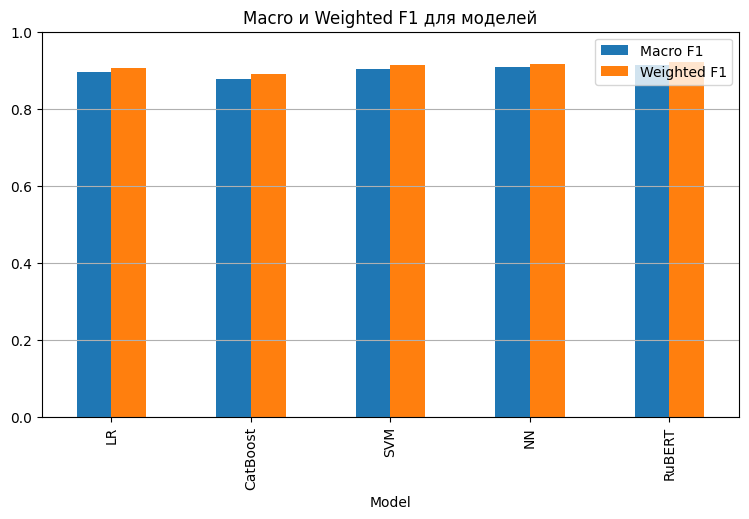

In [88]:
results.set_index("Model")[["Macro F1", "Weighted F1"]].plot(kind="bar", figsize=(9, 5))
plt.title("Macro и Weighted F1 для моделей")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

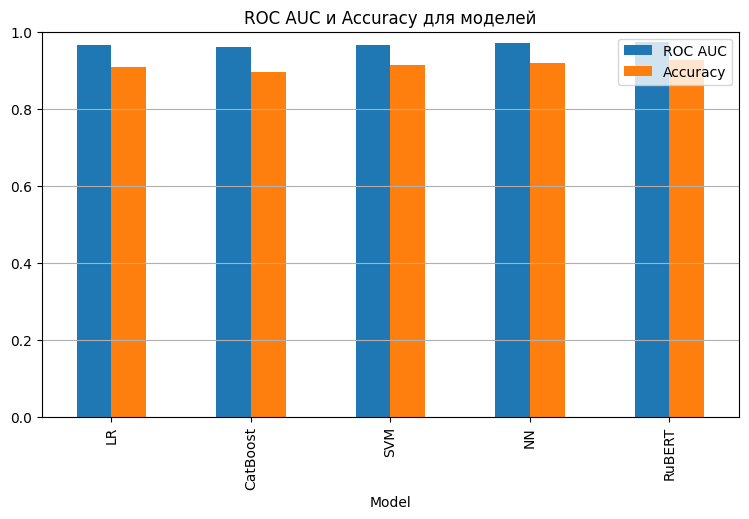

In [87]:
results.set_index("Model")[["ROC AUC", "Accuracy"]].plot(kind="bar", figsize=(9, 5))
plt.title("ROC AUC и Accuracy для моделей")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

###Реализация Телеграм-бота:

Реализация простого Телеграм-бота, который использует обученную модель RuBERT для анализа тональности новостей по URL-ссылке. Это демонстрирует практическое применение разработанной модели. Бот выполняет следующие шаги:

Получает URL от пользователя.

Скачивает HTML-страницу по URL.

Извлекает текстовое содержимое (параграфы).

Подает извлеченный текст на вход модели SentimentClassifier.

Возвращает пользователю предсказанную тональность и уверенность модели.



In [ ]:
import os
import logging
import nest_asyncio
import requests
from bs4 import BeautifulSoup
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, AutoModel
from telegram import Update
from telegram.ext import (
    ApplicationBuilder,
    CommandHandler,
    MessageHandler,
    ContextTypes,
    filters,
)

nest_asyncio.apply()

# Логирование
logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO
)
logger = logging.getLogger(__name__)

# 1. Токенизатор и модель
TOKENIZER_NAME = "DeepPavlov/rubert-base-cased"
MODEL_NAME = "sberbank-ai/ruBert-base"
MODEL_PATH = "best_model_new.pth"

tokenizer = BertTokenizer.from_pretrained(TOKENIZER_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME)

class SentimentClassifier(torch.nn.Module):
    def __init__(self, bert_model, n_classes=2, dropout=0.3):
        super().__init__()
        self.bert = bert_model
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        return self.classifier(self.dropout(pooled))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(base_model).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# 2. Парсер новости
def extract_text(url: str) -> str:
    resp = requests.get(url, timeout=10)
    soup = BeautifulSoup(resp.content, 'html.parser')
    return "\n".join(p.get_text() for p in soup.find_all('p') if p.get_text())

# 3. Предикт
def predict_sentiment(text: str) -> str:
    enc = tokenizer(
        text, truncation=True, padding='max_length', max_length=256, return_tensors='pt'
    )
    input_ids = enc['input_ids'].to(device)
    attn_mask = enc['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attn_mask)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    labels = ['Негативная', 'Позитивная']
    idx = probs.argmax()
    return f"{labels[idx]} (уверенность {probs[idx]:.2f})"

# 4. Хэндлеры Telegram
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text(
        "Пришли ссылку на новость — я скажу, положительная она или отрицательная."
    )

async def handle_url(update: Update, context: ContextTypes.DEFAULT_TYPE):
    url = update.message.text.strip()
    await update.message.reply_text("Скачиваю и анализирую статью…")
    try:
        text = extract_text(url)
        if not text:
            return await update.message.reply_text("Не смог найти текст на странице.")
        result = predict_sentiment(text)
        await update.message.reply_text(f"Результат: {result}")
    except Exception as e:
        logger.error("Ошибка при обработке: %s", e)
        await update.message.reply_text("Не удалось обработать ссылку.")

def main():
    token = os.getenv("TELEGRAM_TOKEN", "***")
    app = ApplicationBuilder().token(token).build()

    app.add_handler(CommandHandler("start", start))
    app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_url))
    app.run_polling()

if __name__ == "__main__":
    main()

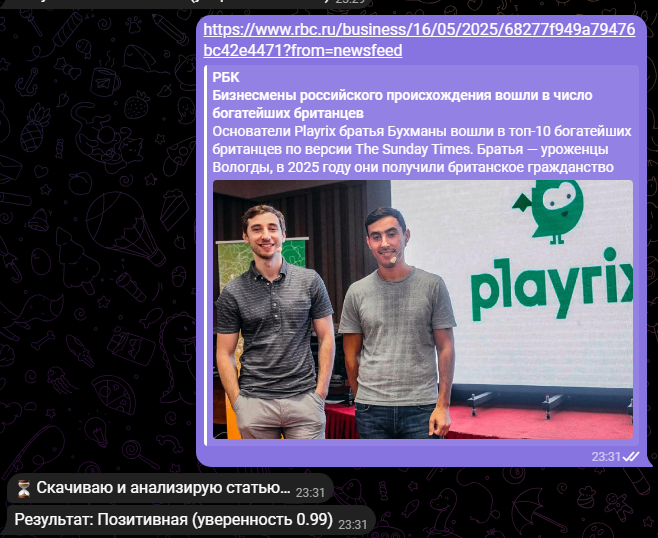

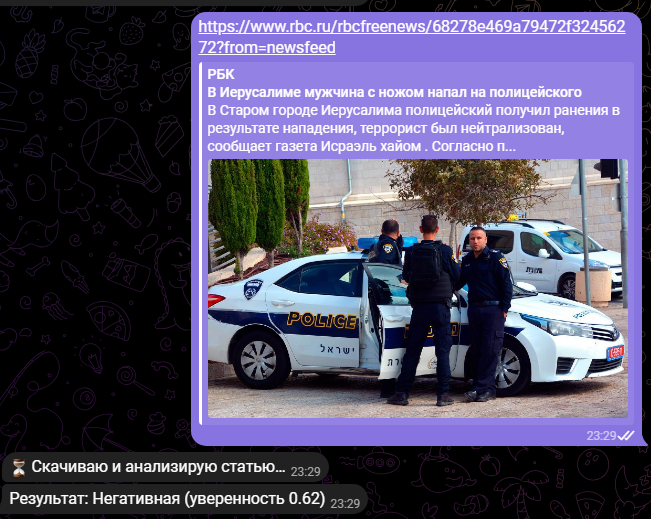

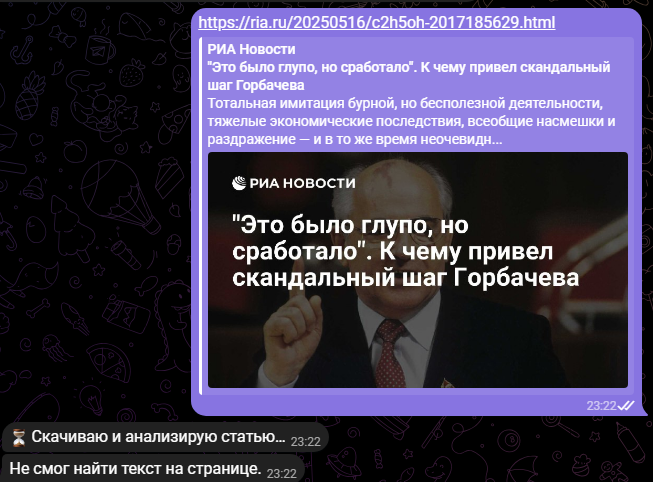